# Notebook es.7

## 7.1

### Assignment

In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Solution

The tail correction is used to compensate the cut off of the potential used to perform the simulation. It can be shown that the tail correction for the internal energy and the pressure are given by the expression
```c++ 
_vtail = 8.0 * M_PI * _rho *((1/(9.0*pow(_r_cut,9))) - (1/(3.0*pow(_r_cut,3))));
```
```c++ 
_ptail = 32.0 * M_PI * _rho / ((1/9.0*pow(_r_cut,9)) - (1/6.0*pow(_r_cut,3)));
```
that I add to the system code. 

## 7.2

### Assignment

Use the NSL simulator code to <span style="color:red">print out **instantaneous** values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo $(N,V,T)$ and Molecular Dynamics $(N,V,E)$ simulations</span> of $M=5\times 10^5$ MC steps or MD time steps (where, for MC, the Metropolis acceptance ratio should be fixed approximately to 50% by changing the value of $dt$ that, in the MC case, represent the amplitude of the step in each direction) in the following thermodynamic conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, for MD $dt^\star=0.001$)

Equilibration is needed both with MC and with MD. With MD, you will observe that starting from a perfect crystalline configuration the temperature, $T$, will not conserve its value. Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$.
<span style="color:red">Perform your MC and MD simulations by re-starting after such equilibration time.</span>

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Solution

To equilibrate MD simulation I perform a simulation using $T_{in}=1.98$. I find that this temperature value approximately bring the system to the temperature requested, as is showed in the figure. I save the last configurations of the system and I start the MD simulations from this positions 

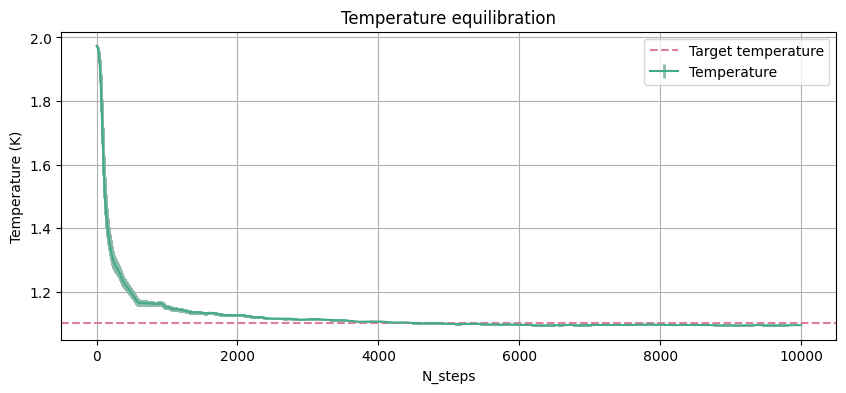

In [1]:
import matplotlib.pyplot as plt
import numpy as np 

data_t = np.loadtxt("NSL_SIMULATOR/OUTPUT_equilibration/temperature.dat")

fig, ax = plt.subplots(1,1,figsize=(10, 4))

ax.errorbar(data_t[:, 0], data_t[:, 2], yerr=data_t[:, 3], label='Temperature', color='#43AA8B', ecolor="#8EBAAC", elinewidth=2, capsize=0)
ax.axhline(y=1.1, label='Target temperature', color='#DC7F9B', linestyle='--')
ax.set_title('Temperature equilibration')
ax.set_xlabel('N_steps')
ax.set_ylabel('Temperature (K)')
ax.legend()
ax.grid(True)

plt.show()

Starting from the equilibrated configuration I produced the data requested using the simulator. I evaluate the autocorrelation for $\frac{U}{N}$ to understand the dimension of the block. This process is necessary because the output producted by the simulation are in general correlated, so they doesn't fulfill the hypotesis of Central Limit Theorem (CLT). 

One way to resolve this problem is to use data blocking: dividing the measure in groups large enough and considering the average in a group as a single measure, we obtain uncorrelated measure for which can be used the CLT. The second figure shows the statistical error estimation in function of the number of step for each block. We can see that for $L_{block} \le 1000 $ the error is significantly understimated, meaning that the values of different blocks are correlated.

/var/folders/vv/r9678hwn58lc9n90r1j77_km0000gn/T/ipykernel_6204/169777347.py:27: RuntimeWarning: invalid value encountered in scalar divide
  ave /= nblocks
/var/folders/vv/r9678hwn58lc9n90r1j77_km0000gn/T/ipykernel_6204/169777347.py:28: RuntimeWarning: invalid value encountered in scalar divide
  ave2 /= nblocks


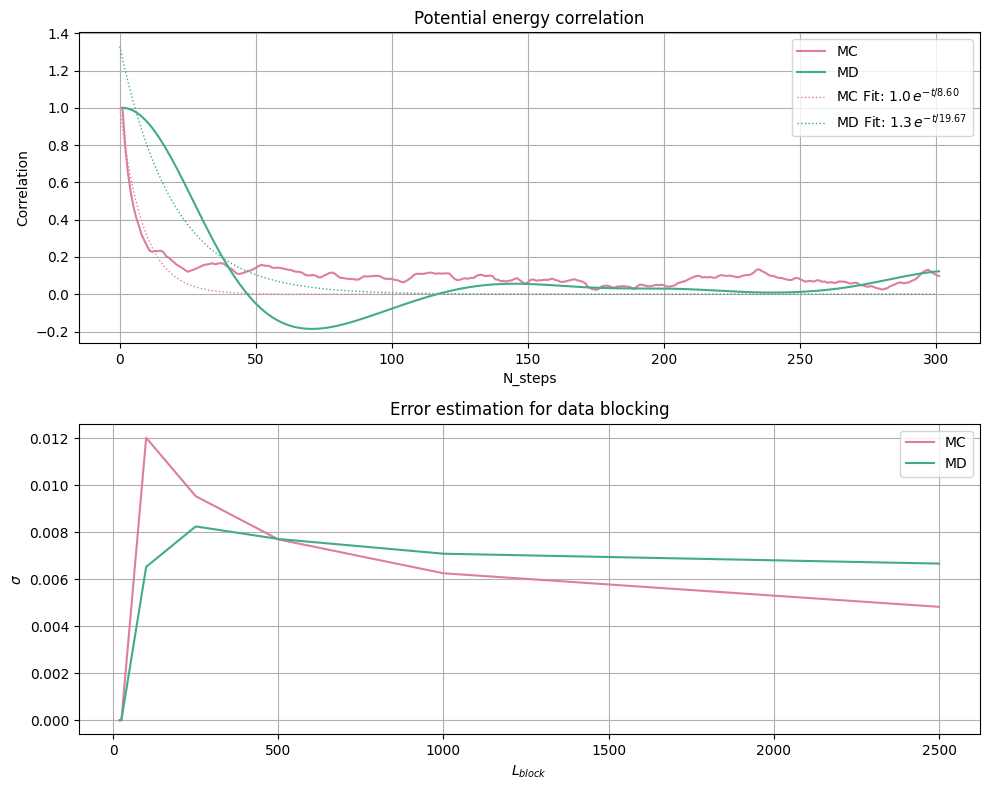

In [66]:
import statsmodels.api as sm
from scipy.optimize import curve_fit
import math

def expo(t, a, b) :
    return a * np.exp(-t/b)

def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)


# blocking average function
def block_average(array, size) :
    nblocks = len(array) // size
    ave = 0
    ave2 = 0
    for i in range(nblocks) :
        sum = 0
        for j in range(size) :
            sum += array[i*size+j]
        sum /= size
        ave += sum
        ave2 += sum*sum
    ave /= nblocks
    ave2 /= nblocks
    return ave, np.sqrt((ave2 - ave*ave) / nblocks)


# computation of autocorrelation function
data_U = np.loadtxt("NSL_SIMULATOR/OUTPUT_MC_7.2/potential_energy.dat")
data_U_md = np.loadtxt("NSL_SIMULATOR/OUTPUT_MD_7.2/potential_energy.dat")
maxlag = 300
acorr = sm.tsa.acf(data_U[:, 1], nlags=maxlag)
acorr_md = sm.tsa.acf(data_U_md[:, 1], nlags=maxlag)


# error estimation for data blocking 
M_th = 10**5 
L_block = [10, 20, 25, 100, 250, 500, 1000, 2500]
U_N_values = np.zeros((len(L_block), 2))
U_N_values_md = np.zeros((len(L_block), 2))
N = np.zeros(len(L_block), dtype=int)

for i in range(len(L_block)):
    N[i] = int(M_th / L_block[i])  # Calculate block size N based on M_th and L_block
    U_N_values[i, 0], U_N_values[i, 1] = block_average(data_U[:, 1], N[i])
    U_N_values_md[i, 0], U_N_values_md[i, 1] = block_average(data_U_md[:, 1], N[i])

x = np.arange(len(acorr))
popt, pcov = curve_fit(expo, x, acorr, bounds=([1, 0], [np.inf, np.inf]))
y_expo = expo(x, *popt)
popt_md, pcov_md = curve_fit(expo, x, acorr_md, bounds=([1, 0], [np.inf, np.inf]))
y_expo_md = expo(x, *popt_md)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(data_U[:maxlag+1, 0], acorr, label='MC', color='#DC7F9B')
ax[0].plot(data_U_md[:maxlag+1, 0], acorr_md, label='MD', color='#43AA8B')
ax[0].plot(x, y_expo, c='#DC7F9B', ls=':', linewidth=1, label='MC Fit: ' + format(popt[0], '.1f') + '$ \, e^{-t /' + format(popt[1], '.2f') + '}$')
ax[0].plot(x, y_expo_md, c='#43AA8B', ls=':', linewidth=1, label='MD Fit: ' + format(popt_md[0], '.1f') + '$ \, e^{-t /' + format(popt_md[1], '.2f') + '}$')
ax[0].set_title('Potential energy correlation')
ax[0].set_xlabel('N_steps')
ax[0].set_ylabel('Correlation')
ax[0].legend()
ax[0].grid(True)


ax[1].plot(L_block, U_N_values[:, 1], color='#DC7F9B', label='MC')
ax[1].plot(L_block, U_N_values_md[:, 1], color='#43AA8B', label='MD')
ax[1].set_title('Error estimation for data blocking')
ax[1].set_xlabel(r'$L_{block}$')
ax[1].set_ylabel(r'$\sigma$')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

## 7.3 

### Assignment

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Solution 

The radial distribution function gives the probability of finding a pair of atoms a distance r apart, relative to the probability expected for a completely random distribution at the same density. It can be evaluated with the relation:
\begin{equation}
    g(r^*) = \frac{1}{ \rho^* N \Delta V^*(r^*)} \left \langle \sum \sum_{i \neq j=1}^N \delta(r^*-| \vec{r_i^*} - \vec{r_j^*} |) \right \rangle.
\end{equation}

It is a useful quantity because it provides insight into the liquid structure and also because the ensemble average of any pair function may be computed directly by knowing it. To evaluate it, the system divide the interval $[0, \frac{L}{2}]$ in $n$ bins and at every measure step it increase the counter relative of a bin, every time that their distance is included in the bin size. Then it normalize the distribution dividing the measures for $\rho N \Delta V(r)$. Here, I report the codification of this process. 
```c++ 
...
if(_measure_gofr){
    bin = int(dr/_bin_size);
    if(bin < _n_bins){
    _measurement(_index_gofr + bin) += 2.0; // 2 particles contribute to the same bin
    }
}
...
```

```c++ 
...
coutf.open("../OUTPUT/gofr.dat",ios::app);
for(int i=0; i<_n_bins; i++){
    double distance = (i+0.5) * _bin_size;
    double V_r = 4.0 * M_PI * (pow(distance + _bin_size/2.0, 3) - pow(distance - _bin_size/2.0, 3))/3; // shell volume
    double norm = 1.0 / ((double)_npart * _rho * V_r); // normalization factor
    average  = _average(_index_gofr +i) * norm;
    sum_average = _global_av(_index_gofr +i) * norm;
    sum_ave2 = _global_av2(_index_gofr +i) * pow(norm,2);
    coutf << setw(12) << blk
        << setw(12) << distance
        << setw(12) << average
        << setw(12) << sum_average/double(blk)
        << setw(12) << this->error(sum_average, sum_ave2, blk) << endl;
}
coutf.close();
...
```

## 7.4 

### Assignment

By means of your upgraded NSL simulator code, equilibrate and <span style="color:red">perform MC NVT and MD NVE simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for these quantities with those obtained via MD NVE simulations in similar thermodynamic conditions.</span>

### Solution 



I performed the simulation under the same conditions as in exercise 7.2. For the analysis, I used 100 blocks of 1000 steps each. The results for the potential energy and the radial distribution function are quite similar. However, the two simulations show different results for the pressure. This is probably because the pressure is estimated in two different ways: in the MD simulation, the pressure is calculated from the kinetic energy.

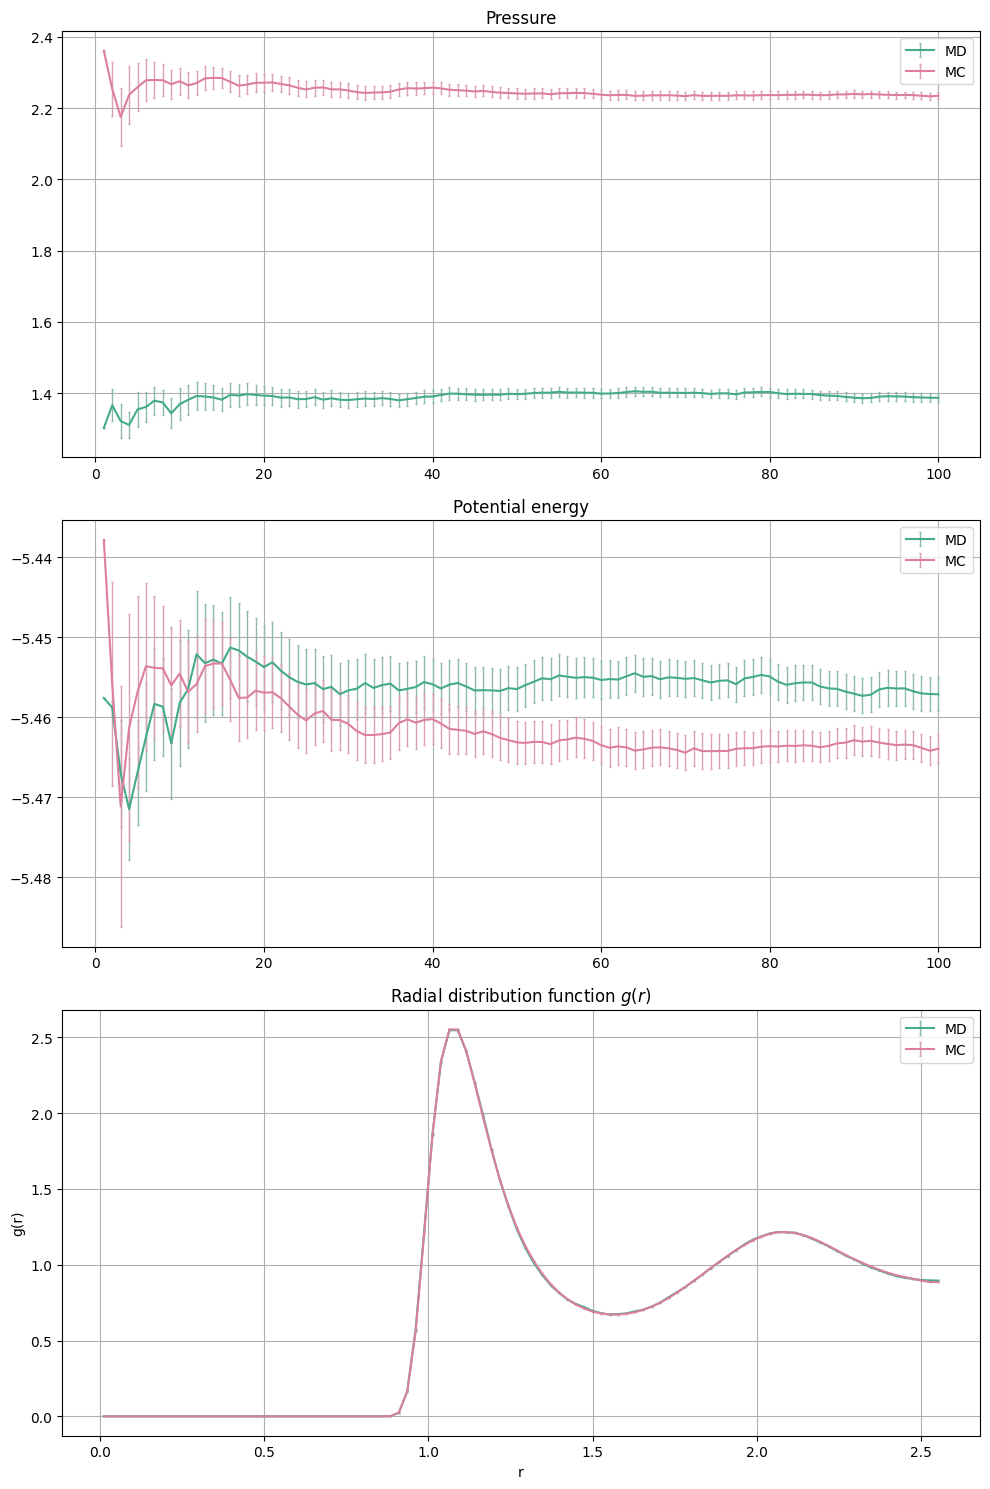

In [67]:
import matplotlib.gridspec as gridspec

#loading data
gofr_MD = np.loadtxt("NSL_SIMULATOR/OUTPUT_MD/gofr.dat")
mask_MD = gofr_MD[:, 0] == 100
pressure_MD = np.loadtxt("NSL_SIMULATOR/OUTPUT_MD/pressure.dat")
pot_MD = np.loadtxt("NSL_SIMULATOR/OUTPUT_MD/potential_energy.dat")
gofr_MC = np.loadtxt("NSL_SIMULATOR/OUTPUT_MC/gofr.dat")
mask_MC = gofr_MC[:, 0] == 100
pressure_MC = np.loadtxt("NSL_SIMULATOR/OUTPUT_MC/pressure.dat")
pot_MC = np.loadtxt("NSL_SIMULATOR/OUTPUT_MC/potential_energy.dat")
  
#plotting the figure
fig, ax = plt.subplots(3,1,figsize=(10,15))


ax[0].set_title('Pressure')
ax[0].errorbar(pressure_MD[:, 0], pressure_MD[:, 2], yerr=pressure_MD[:, 3], label='MD', color='#43AA8B', ecolor="#8EBAAC", elinewidth=1, capsize=1)
ax[0].errorbar(pressure_MC[:, 0], pressure_MC[:, 2], yerr=pressure_MC[:, 3], label='MC', color='#DC7F9B', ecolor="#DA9FB1", elinewidth=1, capsize=1)
ax[0].grid(True)
ax[0].legend()


ax[1].set_title('Potential energy')
ax[1].errorbar(pot_MD[:, 0], pot_MD[:, 2], yerr=pot_MD[:, 3], label='MD', color='#43AA8B', ecolor="#8EBAAC", elinewidth=1, capsize=1)
ax[1].errorbar(pot_MC[:, 0], pot_MC[:, 2], yerr=pot_MC[:, 3], label='MC', color='#DC7F9B', ecolor="#DA9FB1", elinewidth=1, capsize=1)
ax[1].grid(True)
ax[1].legend()


ax[2].set_title(r'Radial distribution function $g(r)$')
ax[2].errorbar(gofr_MD[mask_MD, 1], gofr_MD[mask_MD, 3], gofr_MD[mask_MD, 4], label='MD', color='#43AA8B', ecolor="#8EBAAC", elinewidth=1, capsize=1)
ax[2].errorbar(gofr_MC[mask_MC, 1], gofr_MC[mask_MC, 3], gofr_MC[mask_MC, 4], label='MC', color='#DC7F9B', ecolor="#DA9FB1", elinewidth=1, capsize=1)
ax[2].set_xlabel('r')
ax[2].set_ylabel('g(r)')
ax[2].grid(True)
ax[2].legend()

plt.tight_layout()
plt.show()